### Library import

In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk
import tensorflow as tf
import matplotlib.pyplot as plt

available GPU

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

list구조 [{'S10'}, {'S9'}, {'S8'} --- ]   
print(list_name[0]['S10'].keys())   
print(list_name[0]['S10']['Amuse'].keys())   
print(list_name[0]['S10']['Amuse']['segments'].keys())   
print(list_name[0]['S10']['Amuse']['heartbeat'].keys())   


### Data load

In [6]:
def NAME_TO_DICT(name):
    
    
    '''
    input : name (파일이름)
    output : name 이름을 가진 딕셔너리 
    
    -설명 :
    사람을 구별하기 위해 파일 이름으로,
    list_name 리스트에 파일 이름을 가진 딕셔너리를 저장하기위해
    딕셔너리 생성 후 반환 
    '''
    
    
    file_dict = {name : []}
    return file_dict


def Get_ecg(data):
    
    
    '''
    Get_ECG in .pkl file
    
    input : data ()
    output : 각 클래스 별 ECG 
    
    -설명 : 
    WESAD databse의 .pkl file에서 ECG 데이터를 가져옵니다.
    Amuse, Normal, Stress data를 가져온 뒤 np.array 형태로 반환
    
    '''
    
    
    ecg_v = data['signal']['chest']['ECG'] # singl-chest-ecg 딕셔너리 값
    label = df['label']
    
    normal_ecg = np.array(ecg_v[np.where(label==1)[0]])
    stress_ecg = np.array(ecg_v[np.where(label==2)[0]])
    amuse_ecg = np.array(ecg_v[np.where(label==3)[0]])
    
    print('Get ecg success')
    
    return normal_ecg.flatten(), stress_ecg.flatten(), amuse_ecg.flatten()


def GET_SEGMENTS(signal, waves): 
    # create_dataset에서 호출되는 함수 
    
    
    '''
    -PQ, QRS, ST의 값들을 추출해서 segments 딕셔너리에 추가
    
    input : signal(해당 클래스 ECG 데이터), waves(Peak들의 지점 정보가 담긴 딕셔너리)
    output : Amuse, Normal, Stress에 대한 PQ, QRS, ST 데이터가 담긴 segments 딕셔너리
    
    설명 :
    신호와 peak지점들이 담긴 정보를 받는다.
    for문을 통해 클래스별로 PQ, QRS, ST 간격을 추출
    np.array 형태로 변환한 뒤 반환
    
    '''
    
    
    segments = {
        'PQ': [],
        'QRS': [],
        'ST': []
    }
    
    for i in range(len(waves['ECG_P_Peaks'])):
        if not np.isnan(waves['ECG_P_Onsets'][i]) and not np.isnan(waves['ECG_P_Offsets'][i]):
            segments['PQ'].append(signal[waves['ECG_P_Onsets'][i]: waves['ECG_P_Offsets'][i]])
        
        if not np.isnan(waves['ECG_P_Offsets'][i]) and not np.isnan(waves['ECG_T_Onsets'][i]):
            segments['QRS'].append(signal[waves['ECG_P_Offsets'][i]: waves['ECG_T_Onsets'][i]])
        
        if not np.isnan(waves['ECG_T_Onsets'][i]) and not np.isnan(waves['ECG_T_Offsets'][i]):
            segments['ST'].append(signal[waves['ECG_T_Onsets'][i]: waves['ECG_T_Offsets'][i]])
    
    # Convert lists to numpy arrays
    for key in segments:
        segments[key] = np.array(segments[key])
    
    return segments


def GET_Heartbeat(signal, rpeaks, smapling_rate):
    # create_dataset에서 호출되는 함수 
    
    
    '''
    -PQRST 함수 추출 
    
    input : signal(ECG Data), rpeaks(해당 ECG 데이터의 Rpeak 지점), sampling_rate
    output : 한 주기 씩 저장된 딕셔너리 데이터
    
    설명 :
    해당 신호와 그 신호의 R지점 데이터를 받아 PQRST로 이루어진 한 주기를 추출
    뉴로킷의 nk.ecg_segment 이용
    
    '''
    
    
    segments_Heartbeat = {
        'Heartbeat' : []
    }
    
    qrs_epochs = nk.ecg_segment(signal, rpeaks=rpeaks, sampling_rate=smapling_rate, show=False)
    
    for i in range(1, len(qrs_epochs.keys())):
        segments_Heartbeat['Heartbeat'].append(qrs_epochs[str(i)]['Signal'])
    
    for key in segments_Heartbeat:
        segments_Heartbeat[key] = np.array(segments_Heartbeat[key])
        
    return segments_Heartbeat


def create_dataset(datasets, sampling_rate = 700):
    
    '''
    3개 클래스의 모든 정보를 담긴 dataset을 생성하기 위한 함수
    
    input : datasets 딕셔너리, sampling_rate
    output : GET_SEGMENTS, GET_Heartbeat의 함수들을 통해 딕셔너리에 저장된 데이터와 클래스 라벨이 담긴 딕셔너리 반환
    
    설명 :
    -- Dict 형태 -- 
    1. [class][segments][PQ or QRS or ST] : PQ, QRS, ST 데이터가 담긴 dict
    2. [class][heartbeat][Heartbeat] : 한 주기가 차례대로 담긴 Heartbeat dict
    3. [class][label] : Class 라벨 (Amuse : 0, Normal : 1, Stress : 2)
    
    -- 참고 -- 
    label값, (data, waves, data_label)
    results['Normal, Stress, Amuse']['segments']['PQ', 'QRS', 'ST']
    results['Normal', 'Stress', 'Amuse']['label']
    
    -- 출력 예시 --
    -Example of accessing the results
    print(results['Normal']['segments']['PQ'])  # Access PQ segments for Normal
    print(results['Normal']['label'])           # Access label for Normal (0) 
    '''
    
    
    for label, (data, waves, rpeaks, data_label) in datasets.items(): # .items()를 통해 딕셔너리의 key, value 값을 얻을 수 있음
       
        results[label] = {
            'segments': GET_SEGMENTS(data, waves),
            'heartbeat' : GET_Heartbeat(data, rpeaks, 700),
            'label': data_label
        }
       
    
    return results

# 2024/4/22 03:43
# 문제 1 : 동일한 사람의 데이터가 result에 들어감 
# 문제 2 : 그리고 pq, qrs, st, hb의 개수가 맞아야하는데 맞지않음 

In [8]:
path = "D:/Database/WESAD/"

list_name =[]
results = {}
sampling_rate = 700

for i in range(len(os.listdir(path))):
    for j in range(len(os.listdir(path + os.listdir(path)[2]))):
        if os.path.splitext(path+os.listdir(path)[i])[1] == '.pdf':
            break
        else :
            file_name = os.listdir(path+os.listdir(path)[i])[j]
            if os.path.splitext(file_name)[1] == '.pkl':
                df= pd.read_pickle(path + os.path.splitext(file_name)[0] + '/' + file_name)
                print(file_name + ' load success')
                
                list_name.append(NAME_TO_DICT(os.path.splitext(file_name)[0]))
                #print(list_name)

                Normal, Stress, Amuse = Get_ecg(df)
                print(Normal.shape, Stress.shape, Amuse.shape)

                # 클래스 별로 R-peak 감지 (neurokit 방법)
                _, normal_rpeaks = nk.ecg_peaks(Normal, sampling_rate=sampling_rate, show=False, method='neurokit')
                _, stress_rpeaks = nk.ecg_peaks(Stress, sampling_rate=sampling_rate, show=False, method='neurokit')
                _, amuse_rpeaks = nk.ecg_peaks(Amuse, sampling_rate=sampling_rate, show=False, method='neurokit')
                print('R-peaks detection Success!')

                # 클래스 별로 Peak 추출 
                normal_signals, normal_waves = nk.ecg_delineate(Normal, normal_rpeaks['ECG_R_Peaks'], sampling_rate=sampling_rate)
                stress_signals, stress_waves = nk.ecg_delineate(Stress, stress_rpeaks['ECG_R_Peaks'], sampling_rate=sampling_rate)
                amuse_signals, amuse_waves = nk.ecg_delineate(Amuse, amuse_rpeaks['ECG_R_Peaks'], sampling_rate=sampling_rate)
                print('Signal Peaks delineate Success!')

                # datasets 딕셔너리를 생성한 뒤 해당 값들을 key, value 형태로 저장 
                print('피크 추출 및 딕셔너리에 저장')
                datasets = {
                'Amuse': (Amuse, amuse_waves, amuse_rpeaks['ECG_R_Peaks'], 0),# Label 0
                'Normal': (Normal, normal_waves, normal_rpeaks['ECG_R_Peaks'], 1), # Label 1
                'Stress': (Stress, stress_waves, stress_rpeaks['ECG_R_Peaks'], 2),  # Label 2
                }

                # datasets 생성 후 results에 담기
                results = create_dataset(datasets, sampling_rate = sampling_rate)

                # 파일이름으로 구성된 list_name list에 해당 사람의 데이터들을 저장
                list_name[i][os.path.splitext(file_name)[0]] = results
                

                print("-----------------" ,os.path.splitext(file_name)[0], "전처리 완료---------------------")

                break
            else:
                break
    


S10.pkl load success
Get ecg success
(826000,) (507500,) (260400,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S10 전처리 완료---------------------
S11.pkl load success
Get ecg success
(826000,) (476000,) (257600,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S11 전처리 완료---------------------
S13.pkl load success
Get ecg success
(826001,) (464800,) (267400,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S13 전처리 완료---------------------
S14.pkl load success
Get ecg success
(826000,) (472500,) (260401,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S14 전처리 완료---------------------
S15.pkl load success
Get ecg success
(822500,) (480200,) (260400,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S15 전처리 완료---------------------
S16.pkl load success
Get ecg success
(826000,) (471101,) (257600,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S16 전처리 완료---------------------
S17.pkl load success
Get ecg success
(826700,) (506100,) (260400,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S17 전처리 완료---------------------
S2.pkl load success
Get ecg success
(800800,) (430500,) (253400,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S2 전처리 완료---------------------
S3.pkl load success
Get ecg success
(798000,) (448000,) (262500,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S3 전처리 완료---------------------
S4.pkl load success
Get ecg success
(810601,) (444500,) (260400,)
R-peaks detection Success!
Signal Peaks delineate Success!
피크 추출 및 딕셔너리에 저장


C:\Anaconda3\envs\ecg1\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


----------------- S4 전처리 완료---------------------


KeyboardInterrupt: 

# Pickle 파일 배포 (Dataset)

In [676]:
save_path = 'D:/ICMLA/Database_pkl/'

for i in range(len(list_name)):
    nn = list(list_name[i].keys())
    with open(save_path+nn[0]+'.pkl', 'wb') as f:
        pickle.dump(list_name[i], f)

In [ ]:
for i in range(len(list_name)):
    

# 아래부터는 코드 작업 하는 부분

## Data preprocessing using Neurokit2

### R-peak detection

In [310]:
def NeuroKit_preprocessing(signal, sampling_rate):
    _, signal_rpeaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate, method='neurokit')
    signals, waves = nk.ecg_delineate(signal, signal_rpeaks, sampling_rate=sampling_rate)
    
    print('preprocessing success')
    return waves

In [241]:
waves.keys()

dict_keys(['ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets'])

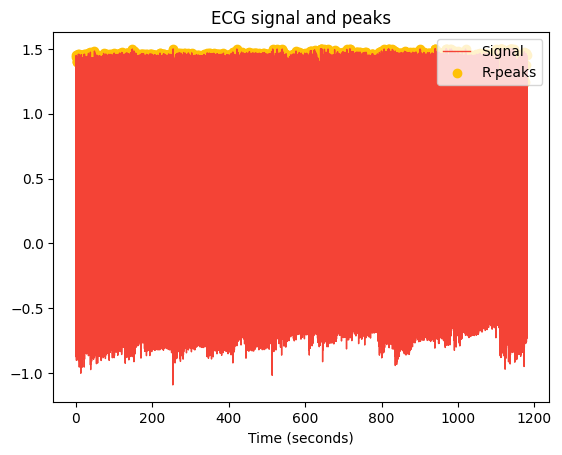

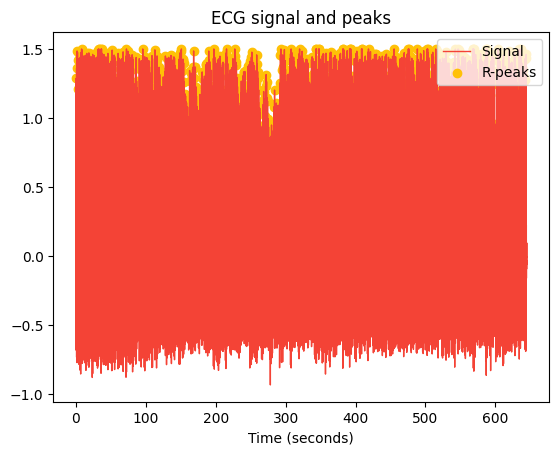

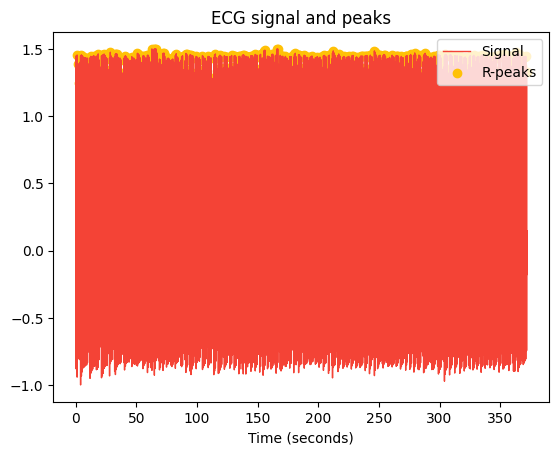

In [311]:
_, normal_rpeaks = nk.ecg_peaks(Normal, sampling_rate=700, show=True,method='neurokit')
_, stress_rpeaks = nk.ecg_peaks(Stress, sampling_rate=700, show=True,method='neurokit')
_, amuse_rpeaks = nk.ecg_peaks(Amuse, sampling_rate=700, show=True,method='neurokit')

In [312]:
normal_signals, normal_waves = nk.ecg_delineate(Normal, normal_rpeaks, sampling_rate=700)
stress_signals, stress_waves = nk.ecg_delineate(Stress, stress_rpeaks, sampling_rate=700)
amuse_signals, amuse_waves = nk.ecg_delineate(Amuse, amuse_rpeaks['ECG_R_Peaks'], sampling_rate=700)

In [313]:
normal_waves.keys()

dict_keys(['ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets'])

### Feature Extraction

### GET PQ, QRS, ST, Heartbeat
input = signal, waves   
output = Select Peak

In [548]:
def GET_SEGMENTS(signal, waves): 
    
    
    # PQ, QRS, ST의 값들을 추출해서 segments 딕셔너리에 추가
    '''
    
    '''
    
    
    segments = {
        'PQ': [],
        'QRS': [],
        'ST': []
    }
    
    for i in range(len(waves['ECG_P_Peaks'])):
        if not np.isnan(waves['ECG_P_Onsets'][i]) and not np.isnan(waves['ECG_P_Offsets'][i]):
            segments['PQ'].append(signal[waves['ECG_P_Onsets'][i]: waves['ECG_P_Offsets'][i]])
        
        if not np.isnan(waves['ECG_P_Offsets'][i]) and not np.isnan(waves['ECG_T_Onsets'][i]):
            segments['QRS'].append(signal[waves['ECG_P_Offsets'][i]: waves['ECG_T_Onsets'][i]])
        
        if not np.isnan(waves['ECG_T_Onsets'][i]) and not np.isnan(waves['ECG_T_Offsets'][i]):
            segments['ST'].append(signal[waves['ECG_T_Onsets'][i]: waves['ECG_T_Offsets'][i]])
    
    # Convert lists to numpy arrays
    for key in segments:
        segments[key] = np.array(segments[key])
    
    return segments


def GET_Heartbeat(signal, rpeaks, smapling_rate):
    
    
    # PQRST 함수 추출 
    '''
    
    '''
    
    
    segments_Heartbeat = {
        'Heartbeat' : []
    }
    
    qrs_epochs = nk.ecg_segment(signal, rpeaks=rpeaks, sampling_rate=smapling_rate, show=False)
    
    for i in range(1, len(qrs_epochs.keys())):
        segments_Heartbeat['Heartbeat'].append(qrs_epochs[str(i)]['Signal'])
    
    for key in segments_Heartbeat:
        segments_Heartbeat[key] = np.array(segments_Heartbeat[key])
        
    return segments_Heartbeat

In [549]:
def create_dataset(datasets, sampling_rate = 700):
    for label, (data, waves, rpeaks, data_label) in datasets.items(): # .items()를 통해 딕셔너리의 key, value 값을 얻을 수 있음
        # label값, (data, waves, data_label)
        # results['Normal, Stress, Amuse']['segments']['PQ', 'QRS', 'ST']
        # results['Normal', 'Stress', 'Amuse']['label']
        results[label] = {
            'segments': GET_SEGMENTS(data, waves),
            'heartbeat' : GET_Heartbeat(data, rpeaks, 700),
            'label': data_label
        }
    # Example of accessing the results
    # print(results['Normal']['segments']['PQ'])  # Access PQ segments for Normal
    # print(results['Normal']['label'])           # Access label for Normal (0)    
    
    return results

In [540]:
# Datasets and corresponding labels
datasets = {
    'Amuse': (Amuse, amuse_waves, amuse_rpeaks['ECG_R_Peaks'], 0),# Label 0
    'Normal': (Normal, normal_waves, normal_rpeaks['ECG_R_Peaks'], 1), # Label 1
    'Stress': (Stress, stress_waves, stress_rpeaks['ECG_R_Peaks'], 2),  # Label 2
    }

results = {}

results = create_dataset(datasets, sampling_rate = 700)

In [551]:
print(results.keys())
print(results['Amuse'].keys())
print(results['Amuse']['segments'].keys())
print(len(results['Amuse']['segments']['PQ']))
print(len(results['Normal']['segments']['PQ']))
print(len(results['Stress']['segments']['PQ']))
print(len(results['Amuse']['segments']))

dict_keys(['Amuse', 'Normal', 'Stress'])
dict_keys(['segments', 'heartbeat', 'label'])
dict_keys(['PQ', 'QRS', 'ST'])
531
1507
858
3


# 데이터 전처리 및 저장까지 
### 잡음제거 X, 원본 상태로 모두 저장함

## P-Q 시각화

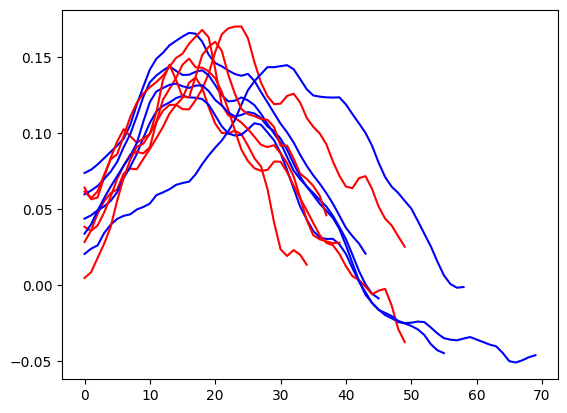

In [9]:
for i in range(100,105):
    plt.plot(normal_ecg[waves['ECG_P_Onsets'][i-1] : waves['ECG_P_Offsets'][i-1]], color='blue', label='Normal')
    plt.plot(stress_ecg[stress_waves['ECG_P_Onsets'][i-1] : stress_waves['ECG_P_Offsets'][i-1]], color='red', label='stress')

## QRS 시각화

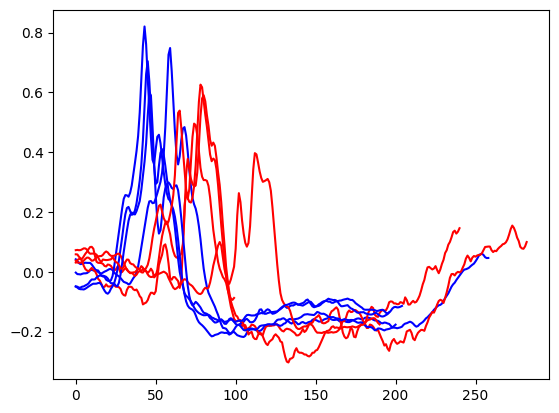

In [10]:
for i in range(1,5):
    plt.plot(normal_ecg[waves['ECG_P_Offsets'][i-1] : waves['ECG_T_Onsets'][i-1]], color='blue', label='Normal')
    plt.plot(stress_ecg[stress_waves['ECG_P_Offsets'][i-1] : stress_waves['ECG_T_Onsets'][i-1]], color='red', label='stress')

# S-T 시각화

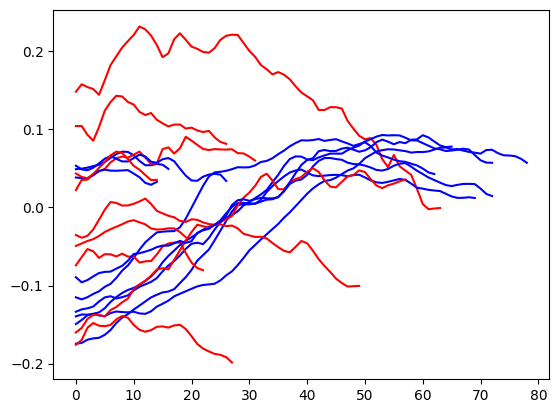

In [11]:
for i in range(1,10):
    plt.plot(normal_ecg[waves['ECG_T_Onsets'][i-1] : waves['ECG_T_Offsets'][i-1]], color='blue', label='Normal')
    plt.plot(stress_ecg[stress_waves['ECG_T_Onsets'][i-1] : stress_waves['ECG_T_Offsets'][i-1]], color='red', label='stress')

## Heartbeat 시각화 (Normal vs Stress)

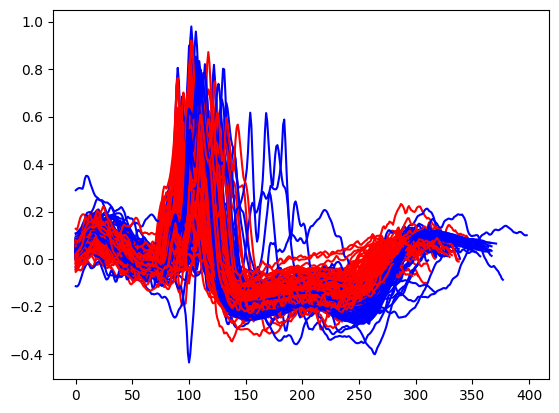

In [12]:
for i in range(1,100):
    plt.plot(normal_ecg[waves['ECG_P_Onsets'][i-1] : waves['ECG_T_Offsets'][i-1]], color='blue', label='Normal')
    plt.plot(stress_ecg[stress_waves['ECG_P_Onsets'][i-1] : stress_waves['ECG_T_Offsets'][i-1]], color='red', label='stress')

## Heartbeat 시각화
## 뉴로킷 사용

In [13]:
print(len(stress_waves['ECG_P_Peaks']))
print(len(waves['ECG_P_Peaks']))

788
1383


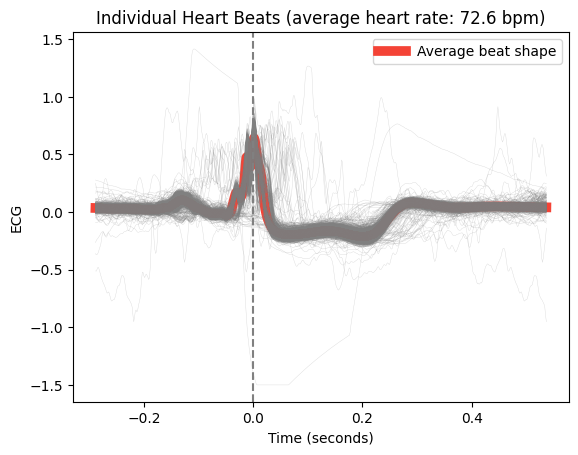

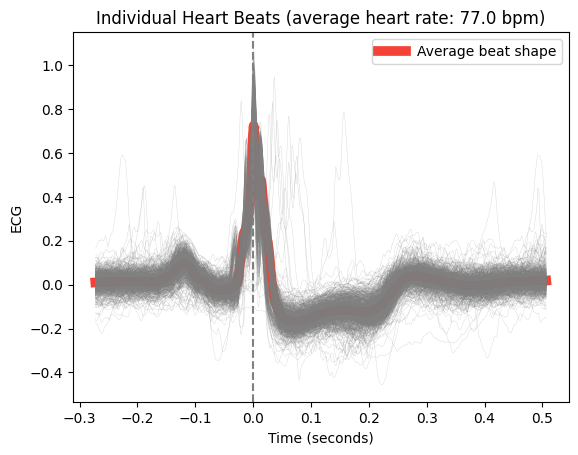

In [14]:
qrs_epochs = nk.ecg_segment(normal_ecg, rpeaks=None, sampling_rate=700, show=True)
stress_qrs_epochs = nk.ecg_segment(stress_ecg, rpeaks=None, sampling_rate=700, show=True)

In [20]:
normal_labeld = np.hstack([normal_arr, np.zeros((normal_arr.shape[0],1))])
stress_labeld = np.hstack([stress_arr, np.ones((stress_arr.shape[0],1))])

In [21]:
normal_df = pd.DataFrame(normal_arr)
stress_df = pd.DataFrame(stress_arr)
normal_df['label'] = 0
stress_df['label'] = 1

In [22]:
Data = pd.concat([normal_df, stress_df])

In [23]:
Data = Data.fillna(0)

In [24]:
Data

,0,1,2,3,4,5,6,7,8,9,...,569,570,571,572,573,574,575,576,577,label
0,0.053146,0.055023,0.059143,0.062485,0.063400,0.062943,0.062485,0.058502,0.059189,0.060837,...,0.071365,0.075439,0.079559,0.082260,0.080429,0.079330,0.077133,0.073105,0.071823,0
1,0.079056,0.074295,0.070633,0.069443,0.069443,0.068069,0.066467,0.061707,0.058273,0.055161,...,0.033920,0.037216,0.039825,0.041336,0.040604,0.037308,0.035751,0.036530,0.035568,0
2,0.021561,0.020096,0.015198,0.010849,0.010208,0.010254,0.007553,0.005905,0.008469,0.016434,...,0.002243,0.001373,0.001877,0.004349,0.004623,0.004578,0.005356,0.007141,0.007645,0
3,0.012772,0.013000,0.015930,0.018539,0.021561,0.020920,0.015244,0.011719,0.010025,0.008881,...,0.011948,0.011581,0.013962,0.012589,0.010162,0.012497,0.014694,0.016296,0.016342,0
4,0.033554,0.032364,0.027924,0.023392,0.021744,0.020691,0.022293,0.024033,0.022842,0.019363,...,0.031448,0.031952,0.034012,0.032272,0.027466,0.023758,0.022568,0.021103,0.021561,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.026962,0.026779,0.025131,0.023392,0.021927,0.021103,0.025040,0.034836,0.043442,0.049026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
783,0.020462,0.021469,0.023300,0.018723,0.011902,0.010483,0.011581,0.009384,0.007553,0.010529,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
784,0.013687,0.019272,0.020096,0.017441,0.016159,0.012589,0.010574,0.010300,0.009933,0.006180,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
785,0.013138,0.014832,0.016891,0.017761,0.017624,0.016251,0.016800,0.017853,0.016159,0.016068,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [25]:
Data = Data.sample(frac=1).reset_index(drop=True)
Data

,0,1,2,3,4,5,6,7,8,9,...,569,570,571,572,573,574,575,576,577,label
0,0.029572,0.026688,0.024765,0.023575,0.023621,0.026276,0.028061,0.026962,0.027512,0.028336,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,0.033005,0.033279,0.033005,0.033737,0.034653,0.034470,0.033920,0.033188,0.033920,0.033051,...,0.029343,0.033646,0.035706,0.036850,0.034332,0.032410,0.028152,0.024033,0.017532,0
2,0.016525,0.016983,0.018265,0.017349,0.016296,0.014877,0.015335,0.013962,0.011948,0.013229,...,0.043076,0.045273,0.044128,0.041977,0.041702,0.044907,0.046463,0.047058,0.045639,0
3,0.039963,0.039597,0.041977,0.044266,0.042664,0.040237,0.040512,0.044174,0.045959,0.045593,...,0.055893,0.054611,0.054520,0.055710,0.056351,0.056122,0.056351,0.056213,0.054794,0
4,0.025406,0.026093,0.025955,0.024399,0.021286,0.019501,0.019226,0.018814,0.018997,0.018173,...,0.036713,0.038223,0.038498,0.040009,0.041702,0.040329,0.037216,0.035751,0.034973,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.033005,0.031174,0.024307,0.017532,0.010941,0.005722,0.000961,-0.001144,-0.002243,0.000687,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2166,0.021561,0.020096,0.015198,0.010849,0.010208,0.010254,0.007553,0.005905,0.008469,0.016434,...,0.002243,0.001373,0.001877,0.004349,0.004623,0.004578,0.005356,0.007141,0.007645,0
2167,0.070862,0.068298,0.065369,0.067703,0.069534,0.065872,0.062485,0.065002,0.064728,0.062897,...,-0.010757,-0.011581,-0.011307,-0.004440,-0.005173,-0.004715,-0.004211,-0.005859,-0.001648,0
2168,0.028793,0.029251,0.030258,0.028427,0.025223,0.023666,0.024490,0.025223,0.025589,0.025131,...,0.050583,0.049759,0.048523,0.046738,0.045593,0.045914,0.047928,0.048981,0.048981,0


In [26]:
X_Data = Data.drop(labels='label', axis=1)

In [27]:
Y_Data = Data['label']

In [28]:
X_Data.shape, Y_Data.shape

((2170, 578), (2170,))

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_Data, Y_Data, test_size=0.15, random_state=42, stratify=Y_Data)

In [30]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1844, 578) (326, 578) (1844,) (326,)


In [31]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

In [32]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(1567, 578) (1567,)
(277, 578) (277,)
(326, 578) (326,)


In [33]:
x_train = np.expand_dims(x_train, axis=2)
x_valid = np.expand_dims(x_valid, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [34]:
x_train.shape

(1567, 578, 1)

In [79]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape=(x_train.shape[1],x_train.shape[2])),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [80]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_8 (Masking)         (None, 578, 1)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 578, 64)           4224      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,705
Trainable params: 16,705
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
history = model.fit(x_train,y_train, validation_data = (x_valid, y_valid), epochs=50)

Epoch 1/50
49/49 [==============================] - 46s 662ms/step - loss: 0.5753 - accuracy: 0.7154 - val_loss: 0.6907 - val_accuracy: 0.6390
Epoch 2/50
49/49 [==============================] - 33s 667ms/step - loss: 0.6321 - accuracy: 0.6522 - val_loss: 0.6194 - val_accuracy: 0.6390
Epoch 3/50
49/49 [==============================] - 33s 675ms/step - loss: 0.6284 - accuracy: 0.6343 - val_loss: 0.5958 - val_accuracy: 0.6679
Epoch 4/50
49/49 [==============================] - 32s 643ms/step - loss: 0.6101 - accuracy: 0.6765 - val_loss: 0.5780 - val_accuracy: 0.7076
Epoch 5/50
49/49 [==============================] - 32s 645ms/step - loss: 0.5871 - accuracy: 0.7128 - val_loss: 0.5732 - val_accuracy: 0.7365
Epoch 6/50
49/49 [==============================] - 33s 674ms/step - loss: 0.6035 - accuracy: 0.7058 - val_loss: 0.6140 - val_accuracy: 0.6895
Epoch 7/50
49/49 [==============================] - 33s 670ms/step - loss: 0.6301 - accuracy: 0.6656 - val_loss: 0.6600 - val_accuracy: 0.6751

In [83]:
pred = model.predict(x_test)

11/11 [==============================] - 1s 88ms/step


In [84]:
(y_test, pred)

(1485    1
 2030    0
 281     0
 871     0
 923     1
        ..
 299     0
 1465    1
 2104    0
 1479    0
 451     1
 Name: label, Length: 326, dtype: int64,
 array([[0.99775547],
        [0.00369775],
        [0.00370008],
        [0.00372649],
        [0.99774086],
        [0.00167828],
        [0.00166788],
        [0.00369685],
        [0.00369625],
        [0.9948762 ],
        [0.00167675],
        [0.9977556 ],
        [0.00167736],
        [0.99773765],
        [0.00370732],
        [0.9977557 ],
        [0.00371301],
        [0.99776065],
        [0.99775785],
        [0.00167668],
        [0.00369173],
        [0.00167547],
        [0.99774534],
        [0.99487597],
        [0.00167312],
        [0.99489236],
        [0.9948782 ],
        [0.00167453],
        [0.99777323],
        [0.00370806],
        [0.9977397 ],
        [0.00369452],
        [0.00370944],
        [0.00167646],
        [0.00368648],
        [0.00369783],
        [0.00370354],
        [0.9977556 ],
  

In [85]:
predicted = []
for i in pred:
    if i > 0.5:
        predicted.append(1)
    else:
        predicted.append(0)
predicted = np.array(predicted)

In [86]:
from sklearn.metrics import classification_report
print( classification_report(y_test, predicted, target_names=['Normal', 'Stress']))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       208
      Stress       1.00      1.00      1.00       118

    accuracy                           1.00       326
   macro avg       1.00      1.00      1.00       326
weighted avg       1.00      1.00      1.00       326



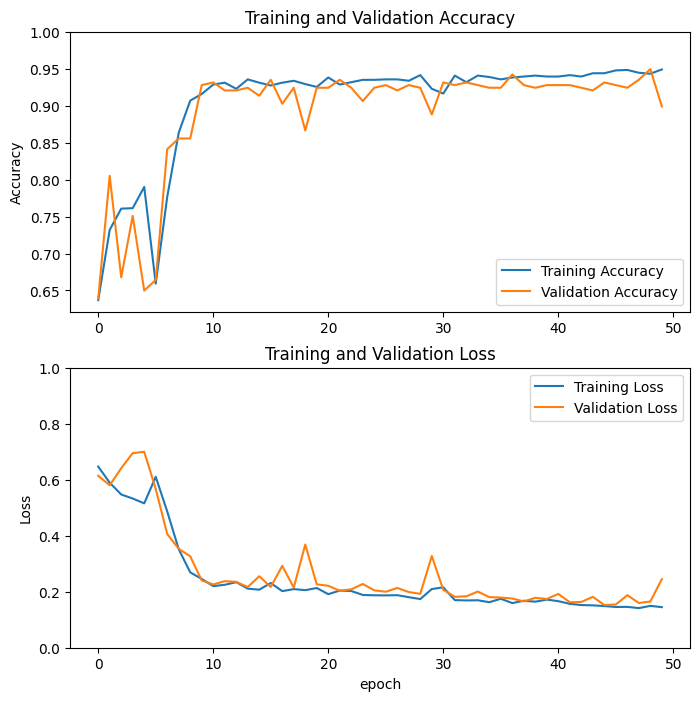

In [76]:
#Plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### LSTM

         precision    recall  f1-score   support

      Normal       0.86      0.95      0.90       208
      Stress       0.89      0.72      0.80       118

    accuracy                           0.87       326
       macro avg       0.88      0.84      0.85       326
    weighted avg       0.87      0.87      0.86       326
    
 
## GRU

              precision    recall  f1-score   support

      Normal       0.90      0.98      0.94       208
      Stress       0.95      0.81      0.87       118

    accuracy                           0.91       326
       macro avg       0.92      0.89      0.90       326
    weighted avg       0.92      0.91      0.91       326
    
## RNN

     precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       208
      Stress       1.00      1.00      1.00       118

    accuracy                           1.00       326
       macro avg       1.00      1.00      1.00       326
    weighted avg       1.00      1.00      1.00       326